## Informed V-JEPA
We investigate how HNN and LNN and VJEPA can learn and represent the physics behind a pendulum.
Steps :
- through openai gym we generate synthetic pendulum images. Each image is labeled by the physical state theta, theta dot. This is the ground truth for the learning and evaluation of physics/
- use utility funvtions to compute and plot the energy and true phase space trajectories of the pendulum, enabling visual checks for consistency and energy conservation.
- train vjepa to predict future image patches, i.e. latent states too, and track loss curves for both jepa objective and physics informed loss we came up with.
- We check the relationship between learned latent representations and true physical variables. We use linear regression to map latents to physical variables with metrics such as R2 and MSE.
- We have plots that show how well the model conserves energy over time and how close its latent space aligns with the true dynamics, ie. try to provide insights how the network encapsulates the underlying physics.

In [1]:
# necessary imports
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from tqdm import tqdm
import os
from PIL import Image, ImageDraw
import glob
import re

import gym

In [2]:
from models import *
from utils.train_functions import *
from utils.helper_functions import *
from utils.datasets import *
from utils.loading_functions import *
from utils.evaluation_functions import *
from utils.evaluation_metrics import *

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
batch_size = 32
ds = PendulumDataset(num_episodes=40, episode_length=40,
                         img_size=64, seq_len=3)
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

Generating pendulum trajectories …


  0%|          | 0/40 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 40/40 [00:00<00:00, 241.80it/s]

Created 1520 windows (seq_len=3)


In [ ]:
if __name__ == "__main__":
    for mode in ["plain","hnn","lnn","hnn+lnn"]:
        cfg = TrainConfig.preset(mode)        # ← gets the right λ-weights
        run_mode(cfg, dl)
    print("\nFinished all experiments; compare logs in ./results/results_<mode>_dense.npz")

In [5]:
base_dir   = "./results_numpy"        # change if you moved them elsewhere
pattern    = "results_*_dense.npz"    # or "results_*.npz" if no suffix

logs = {}   # mode → dict(arrays + 'config')

for path in glob.glob(os.path.join(base_dir, pattern)):
    # extract mode between 'results_' and '_dense.npz'  (works for hnn+lnn)
    m = re.search(r"results_(.+?)_dense\.npz$", os.path.basename(path))
    if not m:
        print("skip", path); continue
    mode = m.group(1)

    npz  = np.load(path, allow_pickle=True)
    arrays = { k: npz[k] for k in npz.files if k != "config" }
    arrays = normalise_keys(arrays)
    arrays["config"] = npz["config"].item()

    logs[mode] = arrays
    print(f"loaded {mode:10} — epochs: {len(arrays['loss_total'])}")
    

loaded hnn+lnn    — epochs: 10
loaded lnn        — epochs: 10
loaded plain      — epochs: 10
loaded hnn        — epochs: 10


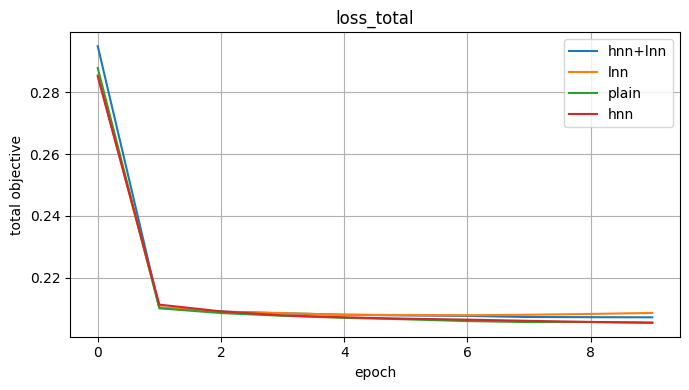

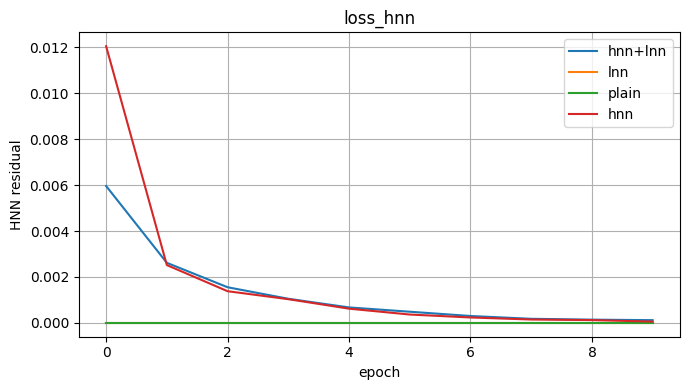

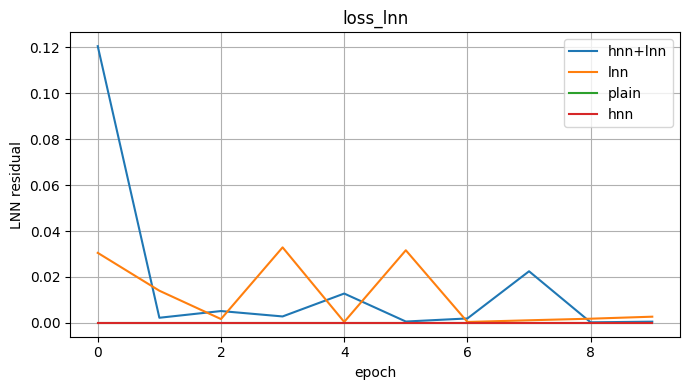

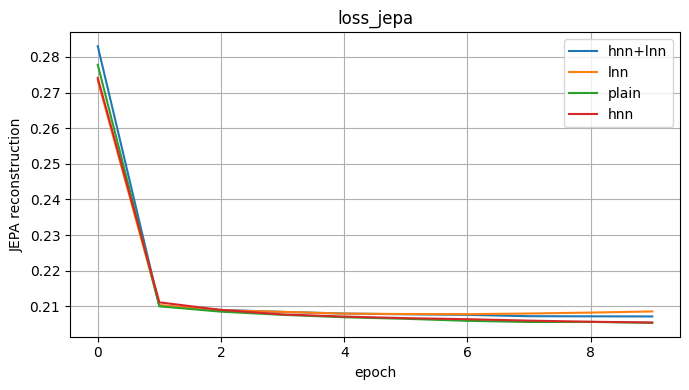

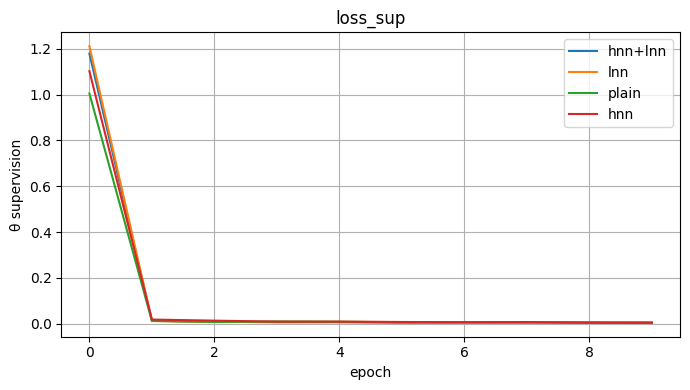

In [6]:
# ------------------------------------------------------------
#  Draw requested comparisons
# ------------------------------------------------------------

for key, label in metrics_to_plot:
    # plot only if *at least one* run recorded that key
    if any(key in rec for rec in logs.values()):
        plot_loss(key, logs, ylabel=label)          # plots every mode that has it
    else:
        print(f"[skip] no log contains '{key}'")

Generating pendulum trajectories …


  0%|          | 0/30 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 30/30 [00:00<00:00, 95.19it/s]


Created 5940 windows (seq_len=3)


rollout:   0%|          | 0/93 [00:00<?, ?it/s]/Users/panaschristou/Library/CloudStorage/OneDrive-Personal/Documents/Internships/MQube/physics_informed_machine_learning/utils/datasets.py:238: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:209.)
  torch.from_numpy(self.frames[i]).float()


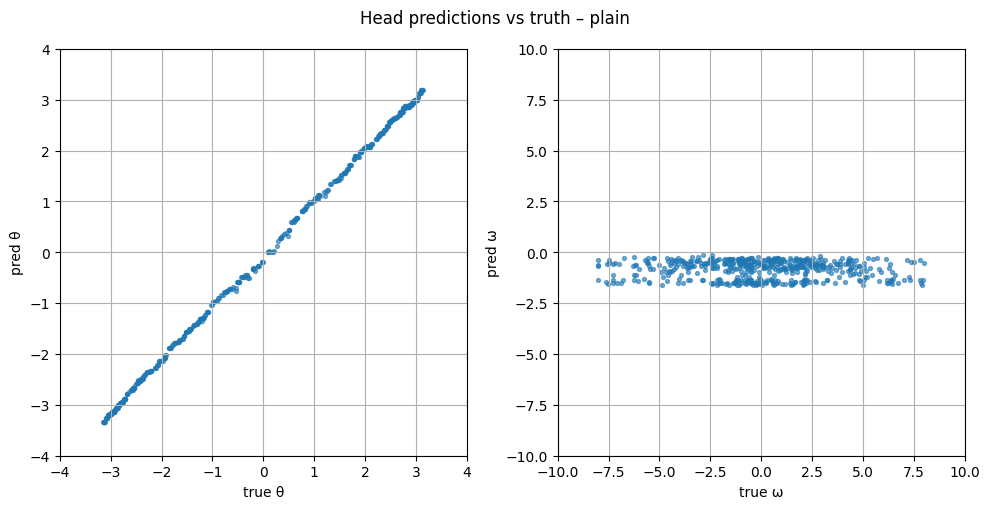

plain    → {'Δ_div': 0.1302, 'E_drift': 10.765, 'Δ_rate': 0.0012, 'E_rate': 0.2093, 'r2_theta': 0.9978, 'mse_theta': 0.0105, 'r2_omega': -0.0948, 'mse_omega': 13.0276} (saved → ./metrics/metrics_plain_dense.json)


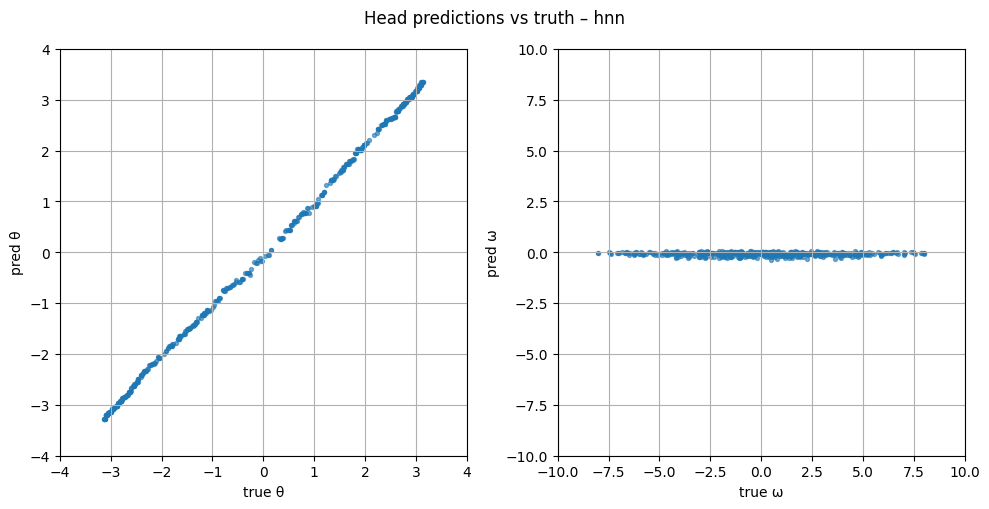

hnn      → {'Δ_div': 0.0964, 'E_drift': 1.2993, 'Δ_rate': 0.0006, 'E_rate': 0.0216, 'r2_theta': 0.9974, 'mse_theta': 0.0125, 'r2_omega': -0.0029, 'mse_omega': 11.9706} (saved → ./metrics/metrics_hnn_dense.json)


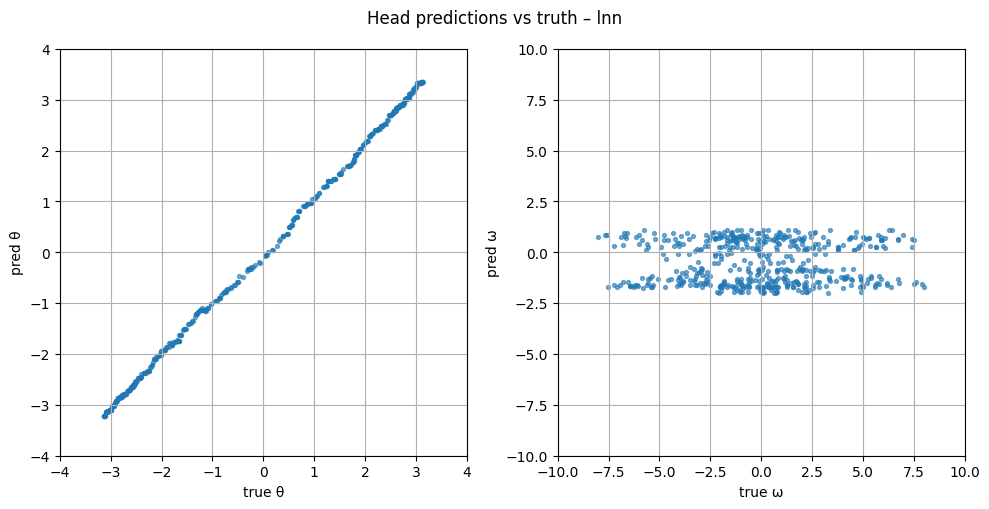

lnn      → {'Δ_div': 1.5789, 'E_drift': 10.4054, 'EL_res': 0.0001, 'Δ_rate': 0.0259, 'E_rate': 0.1952, 'EL_rate': 0.0, 'r2_theta': 0.9969, 'mse_theta': 0.0155, 'r2_omega': -0.1084, 'mse_omega': 12.8182} (saved → ./metrics/metrics_lnn_dense.json)


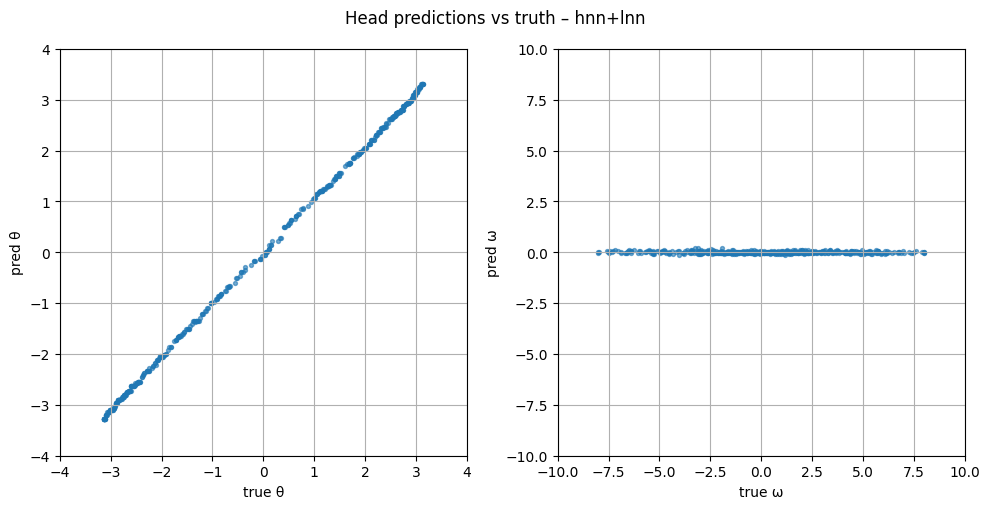

hnn+lnn  → {'Δ_div': 0.8416, 'E_drift': 6.0034, 'EL_res': 0.0, 'Δ_rate': 0.0098, 'E_rate': 0.1034, 'EL_rate': 0.0, 'r2_theta': 0.9986, 'mse_theta': 0.0073, 'r2_omega': -0.0048, 'mse_omega': 12.6723} (saved → ./metrics/metrics_hnn+lnn_dense.json)

✓ combined metrics saved → ./metrics/metrics_all_dense.json


In [3]:
# a PendulumDataset identical to the one you used for training
eval_ds = PendulumDataset(num_episodes=30, episode_length=200,
                         img_size=64, seq_len=3)

metrics = evaluate_all_modes(
    modes        = ["plain", "hnn", "lnn", "hnn+lnn"],
    dataset      = eval_ds,
    cfg          = EvalConfig(),
    combine      = 'mean',   # example: 70 % HNN, 30 % LNN
    plot_scatter = True
)

In [4]:
# Testing the PendulumDataset
# Create a grid of initial conditions for the pendulum
# (theta, omega) pairs
grid = [(th, om)
        for th in np.linspace(-np.pi, np.pi, 15)
        for om in np.linspace(-5, 5, 9)]
ds = PendulumDataset(episode_length=300,
                     init_grid=grid,
                     random_action=False)

Generating pendulum trajectories …


  0%|          | 0/135 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 135/135 [00:01<00:00, 99.43it/s] 

Created 40230 windows (seq_len=3)


In [5]:
# ------------ physical & rollout constants --------------------------
DT, HORIZON = 0.05, 60          # 3 s rollout
g, l, m     = 9.81, 1.0, 1.0

eval_loader = DataLoader(
        PendulumDataset(episode_length=300, seq_len=3,
                        init_grid=[(th, om)
                                   for th in np.linspace(-np.pi, np.pi, 15)
                                   for om in np.linspace(-5, 5, 9)],
                        random_action=False),
        batch_size=64, shuffle=False
    )

Generating pendulum trajectories …


100%|██████████| 135/135 [00:01<00:00, 98.47it/s] 

Created 40230 windows (seq_len=3)


In [5]:
for MODE in ["plain", "hnn", "lnn", "hnn+lnn"]:
    evaluate_mode(
        mode        = MODE,
        eval_loader = eval_loader,
        horizon     = HORIZON,           # explicit, required
        dt          = DT,         # explicit, required
        m           = m, 
        l           = l,
        g           = g,  
        suffix      = "_dense",
        model_dir   = "./models",
        out_dir     = "./metrics_json"
    )

Found prefixed checkpoint: ./models/model_plain_dense.pt


rollout:   0%|          | 0/629 [00:00<?, ?it/s]/Users/panaschristou/Library/CloudStorage/OneDrive-Personal/Documents/Internships/MQube/physics_informed_machine_learning/dataset.py:126: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:209.)
  imgs = [torch.from_numpy(self.frames[i]).float()


plain    → {'Δ_div': 0.1295238584280014, 'E_drift': 10.52688217163086} (saved → ./metrics_json/metrics_plain_dense.json)
Found prefixed checkpoint: ./models/model_hnn_dense.pt


hnn      → {'Δ_div': 0.10257886350154877, 'E_drift': 1.4876724481582642} (saved → ./metrics_json/metrics_hnn_dense.json)
Found prefixed checkpoint: ./models/model_lnn_dense.pt


lnn      → {'Δ_div': 1.8351854085922241, 'E_drift': 9.947497367858887, 'EL_res': 7.486382673960179e-05} (saved → ./metrics_json/metrics_lnn_dense.json)
Found prefixed checkpoint: ./models/model_hnn+lnn_dense.pt


hnn+lnn  → {'Δ_div': 0.09030360728502274, 'E_drift': 2.611436367034912, 'EL_res': 6.875476628920296e-06} (saved → ./metrics_json/metrics_hnn+lnn_dense.json)


Generating pendulum trajectories …


100%|██████████| 135/135 [00:01<00:00, 78.73it/s]


Created 53730 windows (seq_len=3)


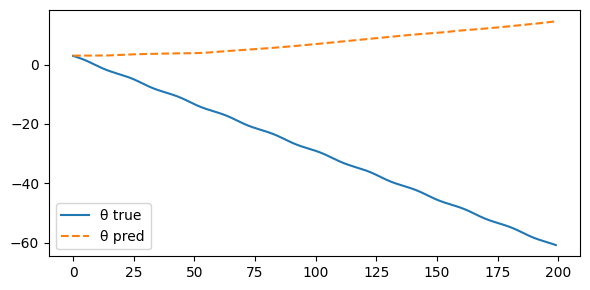

In [44]:
# ────────────────────────────────────────────────────────────────
# 1.  Evaluation loader exactly as you requested
# ----------------------------------------------------------------
eval_loader = DataLoader(
    PendulumDataset(
        episode_length = 400,
        seq_len        = 3,
        init_grid      = [ (th, om)
                           for th in np.linspace(-np.pi,  np.pi, 15)
                           for om in np.linspace(-5.0,    5.0,  9) ],
        random_action  = False
    ),
    batch_size = 64,
    shuffle    = False
)

# ────────────────────────────────────────────────────────────────
# 2.  Purely analytic simple-pendulum roll-out  (explicit Euler)
# ----------------------------------------------------------------
def true_rollouts(
    loader,
    *,
    horizon: int,
    dt: float,
    g : float = 9.81,
    l : float = 1.0,
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Return two tensors of shape **(N, horizon)** with the analytic θ(t), ω(t)
    for *every* (θ₀, ω₀) present in `loader`.
    """
    θ_batches, ω_batches = [], []
    for _, states in loader:                         # we ignore the images
        θ0 = states[:, 0, 0]                         # (B,)
        ω0 = states[:, 0, 1]

        B = θ0.size(0)
        θ = torch.zeros(B, horizon)
        ω = torch.zeros(B, horizon)
        θ[:, 0] = θ0
        ω[:, 0] = ω0

        for t in range(1, horizon):
            α = -(g / l) * torch.sin(θ[:, t-1])
            ω[:, t] = ω[:, t-1] + α * dt
            θ[:, t] = θ[:, t-1] + ω[:, t] * dt

        θ_batches.append(θ)
        ω_batches.append(ω)

    return torch.cat(θ_batches), torch.cat(ω_batches)


# ────────────────────────────────────────────────────────────────
# 3.  Network roll-outs via *your* rollout() helper
# ----------------------------------------------------------------
def nn_rollouts(
    vjepa, head,
    loader,
    *,
    horizon: int,
    dt     : float,
    device : torch.device | str = "cpu",
    hnn=None, lnn=None, combine=None
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Return θ̂(t), ω̂(t) of shape (N, horizon) for every sequence in `loader`.
    """
    vjepa, head = vjepa.to(device).eval(), head.to(device).eval()
    if hnn is not None: hnn = hnn.to(device).eval()
    if lnn is not None: lnn = lnn.to(device).eval()

    θ_preds, ω_preds = [], []

    with torch.no_grad():
        for seq, _ in loader:                        # seq: (B,T,3,64,64)
            seq = seq.to(device)
            # rollout() expects an *iterable* of (seq,label) tuples,
            # so we give it a *list* containing exactly our batch:
            θ_batch, ω_batch, _ = rollout(
                vjepa, head,
                eval_loader = [(seq, torch.zeros_like(_))],  # dummy label
                horizon     = horizon,
                dt          = dt,
                hnn         = hnn,
                lnn         = lnn,
                combine     = combine
            )
            θ_preds.append(θ_batch.cpu())
            ω_preds.append(ω_batch.cpu())

    return torch.cat(θ_preds), torch.cat(ω_preds)


# ────────────────────────────────────────────────────────────────
# 4.  Quick demo  ––  pick any of your checkpoints
# ----------------------------------------------------------------
if __name__ == "__main__":
    horizon = 200
    dt      = 0.05

    # load *one* experiment (change mode as you like)
    vjepa, head, hnn, lnn = load_net("hnn+lnn", suffix="_dense", model_dir="./models")

    # ground-truth
    θ_true, ω_true = true_rollouts(eval_loader, horizon=horizon, dt=dt)

    # network prediction
    θ_pred, ω_pred = nn_rollouts(
        vjepa, head,
        eval_loader,
        horizon = horizon,
        dt      = dt,
        hnn     = hnn,
        lnn     = lnn,
        combine = "mean"           # or "hnn" / "lnn" / None / ("blend", w)
    )

    # sanity-check one trajectory (index 0)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,3))
    plt.plot(θ_true[0],  label="θ true")
    plt.plot(θ_pred[0], "--", label="θ pred")
    plt.legend(); plt.tight_layout(); plt.show()

In [45]:
import numpy as np, torch, matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from utils.datasets   import PendulumDataset
from utils.helper_functions   import rollout
from utils.loading_functions  import load_net

# ─── 1. build the evaluation loader (unchanged) ─────────────────────────
eval_loader = DataLoader(
    PendulumDataset(
        episode_length = 300,
        seq_len        = 3,
        init_grid      = [ (th, om)
                           for th in np.linspace(-np.pi,  np.pi, 15)
                           for om in np.linspace(-5.0,    5.0,  9) ],
        random_action  = False),
    batch_size = 64,
    shuffle    = False
)

# ─── 2. pick WHICH initial pair you want to visualise ───────────────────
target_ic = ( np.pi/3 , 0.0 )      # 60° , 0 rad s⁻¹   (example)

# helper to locate the FIRST window that starts from that IC
def find_first_window(loader, ic, atol=1e-4):
    """Return (batch_idx, sample_idx) pointing at the first window
    whose very first frame matches `ic = (θ0, ω0)`."""
    θ0, ω0 = ic
    for b, (_, states) in enumerate(loader):
        θ_batch = states[:, 0, 0].numpy()
        ω_batch = states[:, 0, 1].numpy()
        for i, (θ, ω) in enumerate(zip(θ_batch, ω_batch)):
            if np.isclose(θ, θ0, atol=atol) and np.isclose(ω, ω0, atol=atol):
                return b, i
    raise ValueError("requested IC not present in loader")

batch_idx, sample_idx = find_first_window(eval_loader, target_ic)

# ─── 3. extract that single 3-frame window and feed it to rollout() ─────
seq, _ = next(iter(torch.utils.data.Subset(eval_loader.dataset,
                                           [batch_idx*64 + sample_idx])))
seq   = seq.unsqueeze(0)                               # (1,T,3,H,W)
dummy = torch.zeros(1, 2)                              # placeholder label
loader= DataLoader(TensorDataset(seq, dummy))

# ground-truth analytic -----------------------------------------------------------------
def true_rollout_single(ic, horizon, dt, g=9.81, l=1.0):
    θ0, ω0 = ic
    θ = torch.empty(horizon);  ω = torch.empty(horizon)
    θ[0], ω[0] = θ0, ω0
    for t in range(1, horizon):
        α      = -(g/l) * math.sin(θ[t-1])
        ω[t]   = ω[t-1] + α * dt
        θ[t]   = θ[t-1] + ω[t] * dt
    return θ.numpy(), ω.numpy()

θ_true, _ = true_rollout_single(target_ic, horizon=200, dt=0.05)

# network prediction --------------------------------------------------------------------
vjepa, head, hnn, lnn = load_net("hnn+lnn", suffix="_dense", model_dir="./models")
θ_pred, _, _ = rollout(vjepa.eval(), head.eval(),
                       eval_loader = loader,
                       horizon     = 200,
                       dt          = 0.05,
                       hnn         = hnn,
                       lnn         = lnn,
                       combine     = "mean")

θ_pred = θ_pred.squeeze(0).numpy()

# ─── 4. plot the two curves ─────────────────────────────────────────────
plt.figure(figsize=(6,3))
plt.plot(θ_true, label="θ true")
plt.plot(θ_pred, "--", label="θ pred")
plt.title(f"Trajectory from IC θ₀={target_ic[0]:.2f}, ω₀={target_ic[1]:.2f}")
plt.xlabel("time-step"); plt.ylabel("θ [rad]")
plt.legend(); plt.tight_layout(); plt.show()

Generating pendulum trajectories …


  0%|          | 0/135 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 135/135 [00:01<00:00, 97.83it/s] 


Created 40230 windows (seq_len=3)


ValueError: requested IC not present in loader